In [91]:
from pathlib import Path
import matplotlib as mpl
import xarray as xr

In [92]:
from pathlib import Path

from bs_fdbck.util.BSOA_datamanip import ds2df_inc_preprocessing
from bs_fdbck.util.collocate.collocateLONLAToutput import CollocateLONLATout
from bs_fdbck.util.collocate.collocate_echam_salsa import CollocateModelEcham
import useful_scit.util.log as log

from bs_fdbck.util.plot.BSOA_plots import make_cool_grid, plot_scatter

log.ger.setLevel(log.log.INFO)
import time
import xarray as xr
import matplotlib.pyplot as plt

In [93]:
from bs_fdbck.util.plot.BSOA_plots import cdic_model

In [94]:
from bs_fdbck.constants import path_measurement_data
select_station = 'SMR'
postproc_data = path_measurement_data /'model_station'/select_station
postproc_data_obs = path_measurement_data /select_station/'processed'

In [95]:
path_comb_data_full_time =postproc_data_obs /'SMEAR_data_comb_hourly.csv'

In [96]:
plot_path = Path(f'Plots/{select_station}')

In [97]:
def make_fn_eval(case,_type):
    #_x = v_x.split('(')[0]
    #_y = v_y.split('(')[0]
    f = f'evalOA_echam_{case}_{_type}_{select_station}.png'
    return plot_path /f

In [98]:
plot_path.mkdir(exist_ok=True, parents=True)

## Read in model data. 

In [99]:
models = ['ECHAM-SALSA','NorESM', 'EC-Earth', 'UKESM']
mod2cases = {'ECHAM-SALSA' : ['SALSA_BSOA_feedback'],
             'NorESM' : ['OsloAero_intBVOC_f09_f09_mg17_fssp'],
             'EC-Earth' : ['ECE3_output_Sara'],
             'UKESM' : ['AEROCOMTRAJ'],
             'Observations':['Obs'],
            }
di_mod2cases = mod2cases.copy()

In [100]:
from bs_fdbck.preprocess.launch_monthly_station_collocation import launch_monthly_station_output
from bs_fdbck.util.Nd.sizedist_class_v2.SizedistributionBins import SizedistributionStationBins
from bs_fdbck.util.collocate.collocateLONLAToutput import CollocateLONLATout
from bs_fdbck.data_info.variable_info import list_sized_vars_nonsec, list_sized_vars_noresm
import useful_scit.util.log as log
log.ger.setLevel(log.log.INFO)
import time

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt

In [102]:
import numpy as np

In [103]:
import numpy as np
from sklearn.linear_model import LinearRegression, BayesianRidge

## Constants:

In [104]:
R = 287.058
pressure = 1000. #hPa
kg2ug = 1e9
temperature = 273.15

In [105]:
import pandas as pd

## Read in model data

In [106]:
dic_df_pre=dict()
for mod in models:
    print(mod)
    dic_df_pre[mod] = dict()
    for ca in mod2cases[mod]:
        print(mod, ca)
        fn_out = postproc_data/f'{select_station}_station_{mod}_{ca}.csv'
        print(fn_out)
        dic_df_pre[mod][ca] = pd.read_csv(fn_out, index_col=0)
        dic_df_pre[mod][ca].index = pd.to_datetime(dic_df_pre[mod][ca].index)
        #dic_df_mod_case[mod][ca].to_csv(fn_out)

ECHAM-SALSA
ECHAM-SALSA SALSA_BSOA_feedback
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/SMR/SMR_station_ECHAM-SALSA_SALSA_BSOA_feedback.csv
NorESM
NorESM OsloAero_intBVOC_f09_f09_mg17_fssp
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/SMR/SMR_station_NorESM_OsloAero_intBVOC_f09_f09_mg17_fssp.csv
EC-Earth
EC-Earth ECE3_output_Sara
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/SMR/SMR_station_EC-Earth_ECE3_output_Sara.csv
UKESM
UKESM AEROCOMTRAJ
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/SMR/SMR_station_UKESM_AEROCOMTRAJ.csv


In [107]:
for mod in models:
    for ca in mod2cases[mod]:
        _df = dic_df_pre[mod][ca]
        for v in ['OA','N50','N100','N200']:
            if f'{v}_STP' in _df.columns:
                if v in _df.columns:
                    _df = _df.rename({v:f'{v}_orig'}, axis=1)
                _df = _df.rename({f'{v}_STP':v}, axis=1)
        dic_df_pre[mod][ca] = _df

In [108]:
for mo in ['EC-Earth','UKESM']:
    if mo in models:
        for ca in mod2cases[mo]:
            dic_df_pre[mo][ca]['OAG'] = dic_df_pre[mo][ca]['OA']

### Double check EC-Earth

In [109]:
mo = 'EC-Earth'
_df = dic_df_pre[mo][mod2cases[mo][0]]

In [110]:
_df['hour'] = _df.index.hour

In [111]:
_df['hour'].unique()

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23,  0,  1])

<AxesSubplot:xlabel='hour'>

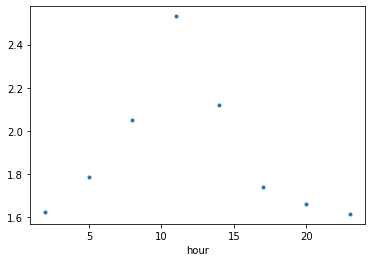

In [115]:
_df.groupby('hour').mean()['OA'].plot(marker='.')

<AxesSubplot:xlabel='hour'>

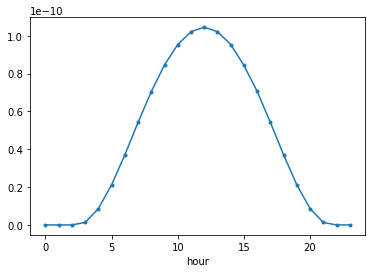

In [113]:
_df.groupby('hour').mean()['emiisop'].plot(marker='.')

<AxesSubplot:xlabel='hour'>

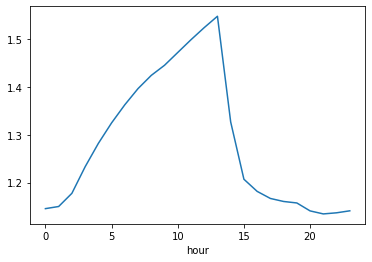

In [24]:
_df.groupby('hour').mean()['POM'].plot()

<AxesSubplot:xlabel='hour'>

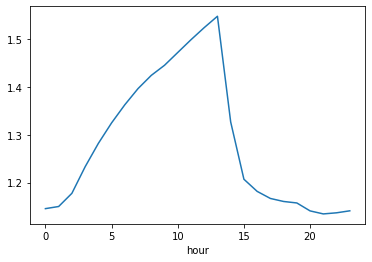

In [25]:
_df.groupby('hour').mean()['POM'].plot()

<AxesSubplot:xlabel='hour'>

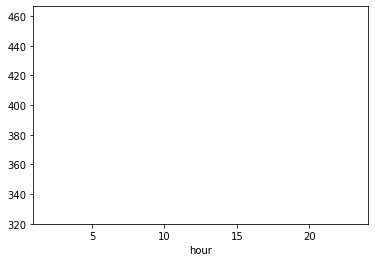

In [26]:
_df.groupby('hour').mean()['N100'].plot()

## Read in observations

In [27]:
df_obs = pd.read_csv(path_comb_data_full_time,index_col=0)

In [28]:
df_obs = df_obs.rename({'Org_STP':'OA'}, axis=1)

In [29]:
dic_df_pre['Observations']=dict()
dic_df_pre['Observations']['Observations'] = df_obs
dic_df_pre['Observations']['Observations'].index = pd.to_datetime(dic_df_pre['Observations']['Observations'].index)

In [30]:
mod2cases['Observations']= ['Observations']

## Set uo dic with all OA values from models

In [31]:
dic_df_mod_case = dic_df_pre

In [32]:
dic_mod_oa = dict()
#dic_mod_soa = dict()
dic_mod_all = dict()


for mod in models:
    dic_mod_oa[mod] = dict()
    #dic_mod_soa[mod] = dict()
    dic_mod_all[mod] = dict()
    for ca in di_mod2cases[mod]:
        dic_mod_oa[mod][ca] = dict()
        #dic_mod_soa[mod][ca] = dict()
        dic_mod_all[mod][ca] = dict()
    
    
for mo in models:
    print(mo)
    for ca in di_mod2cases[mo]:
        print(ca)
        _df = dic_df_mod_case[mo][ca]
        dic_mod_oa[mo][ca] =_df['OA']
        #dic_mod_soa[mo][ca][i] =_df['SOA']
        dic_mod_all[mo][ca] =_df
    



ECHAM-SALSA
SALSA_BSOA_feedback
NorESM
OsloAero_intBVOC_f09_f09_mg17_fssp
EC-Earth
ECE3_output_Sara
UKESM
AEROCOMTRAJ


<AxesSubplot:xlabel='time'>

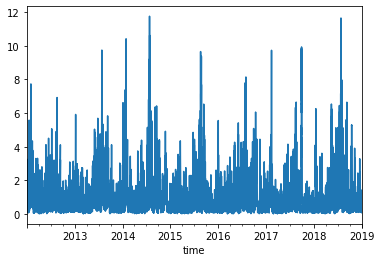

In [33]:
dic_df_pre['ECHAM-SALSA']['SALSA_BSOA_feedback']['OA'].plot()

(390048.0, 390792.0)

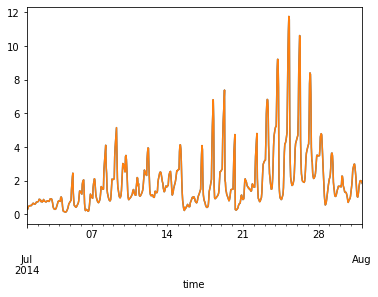

In [34]:
dic_df_pre['ECHAM-SALSA']['SALSA_BSOA_feedback'].resample('h').ffill()['OA'].plot()         
dic_df_pre['ECHAM-SALSA']['SALSA_BSOA_feedback']['OA'].plot()
plt.xlim(['2014-07','2014-08'])

## Merge with observations:

In [35]:
dic_df_mod_case = dic_df_pre.copy()

In [36]:
mask_obs_OA =  dic_df_pre['Observations']['Observations']['OA'].notnull()

In [37]:
_df = dic_df_pre['Observations']['Observations']['OA'].rename('Obs')

df_OA_all = pd.DataFrame(_df)
df_OAG_all = pd.DataFrame(_df)

In [38]:
df_OA_all

,Obs
time,
2012-01-01 00:00:00,NaN
2012-01-01 01:00:00,NaN
2012-01-01 02:00:00,NaN
2012-01-01 03:00:00,NaN
2012-01-01 04:00:00,NaN
...,...
2020-12-31 19:00:00,NaN
2020-12-31 20:00:00,NaN
2020-12-31 21:00:00,NaN


In [39]:
for mod in dic_df_pre.keys():
    if mod=='Observations':
        continue
    print(mod)
    for ca in dic_df_pre[mod].keys():
        if len(dic_df_pre[mod].keys())==1:
            use_name = mod
        else: 
            use_name = f'{mod}: {ca}'
        df_OA_all[use_name] = dic_df_pre[mod][ca]['OA']
        df_OAG_all[use_name] = dic_df_pre[mod][ca]['OAG']


#df_OA_all = df_OA_all[df_OA_all[mod].notna()]
df_OA_all = df_OA_all[df_OA_all['Obs'].notna()]
#df_OAG_all = df_OAG_all[df_OAG_all[mod].notna()]
df_OAG_all = df_OAG_all[df_OAG_all['Obs'].notna()]

ECHAM-SALSA
NorESM
EC-Earth
UKESM


In [40]:
df_OA_all

,Obs,ECHAM-SALSA,NorESM,EC-Earth,UKESM
time,,,,,
2012-05-24 14:00:00,3.855590,0.521079,0.880730,2.321318,1.156147
2012-05-24 15:00:00,3.722964,0.495629,0.892980,NaN,NaN
2012-05-24 16:00:00,3.481069,0.629300,0.903716,NaN,NaN
2012-05-24 17:00:00,3.249105,0.727798,0.913719,1.252269,1.323446
2012-05-24 18:00:00,2.435595,0.919183,0.924918,NaN,NaN
...,...,...,...,...,...
2017-12-31 19:00:00,1.577723,0.346672,3.018541,NaN,NaN
2017-12-31 20:00:00,1.742238,0.447327,3.016776,2.493944,0.571691
2017-12-31 21:00:00,1.743366,0.480732,2.944646,NaN,NaN


In [41]:
orgname={'NorESM' : 'OA',
         'ECHAM-SALSA': 'OA'}

In [42]:
seasons2months = {'DJF':[12,1,2],
        'MAM': [3,4,5],
        'JJA':[6,7,8],
        'SON':[9,10,11],
       }

In [43]:
seasons2months2 = {'JFM': [ 1, 2,3], 'AMJ': [ 4, 5,6], 'JAS': [ 7, 8,9], 'OND': [ 10, 11,12]}

### Calculate anomaly from daily average

In [44]:
df_anom_OA = df_OA_all-df_OA_all.resample('D').mean().resample('h').ffill(limit=24)
df_anom_OAG = df_OAG_all-df_OAG_all.resample('D').mean().resample('h').ffill(limit=24)

In [45]:
df_anom_OAG = df_anom_OAG[df_anom_OAG['Obs'].notna()]
df_anom_OA = df_anom_OA[df_anom_OA['Obs'].notna()]

In [46]:
df_anom_OA

,Obs,ECHAM-SALSA,NorESM,EC-Earth,UKESM
time,,,,,
2012-05-24 14:00:00,0.576490,-0.687863,-0.119685,0.812249,-0.454285
2012-05-24 15:00:00,0.443864,-0.713313,-0.107435,NaN,NaN
2012-05-24 16:00:00,0.201969,-0.579641,-0.096698,NaN,NaN
2012-05-24 17:00:00,-0.029995,-0.481143,-0.086696,-0.256800,-0.286987
2012-05-24 18:00:00,-0.843505,-0.289759,-0.075497,NaN,NaN
...,...,...,...,...,...
2017-12-30 20:00:00,0.095449,0.006445,-0.393215,0.195200,0.109347
2017-12-30 21:00:00,-0.547553,0.029962,-0.287146,NaN,NaN
2017-12-30 22:00:00,0.236389,0.068240,-0.128513,NaN,NaN


In [47]:
linestyle_dic = {
    'Obs': 'solid',
    'NorESM':'dashdot',
    'UKESM':'dashdot',
    'ECHAM-SALSA':'-.',
    'EC-Earth':'-.',
}

## Choose months: 

In [48]:
months = [1,2,3,4,5,6,7,8,9,10,11,12]
df_OA_all = df_OA_all[df_OA_all.index.month.isin(months)]
df_OAG_all = df_OAG_all[df_OAG_all.index.month.isin(months)]                      

df_anom_OA = df_anom_OA[df_anom_OA.index.month.isin(months)]
df_anom_OAG = df_anom_OAG[df_anom_OAG.index.month.isin(months)]

In [49]:
df_OA_all

,Obs,ECHAM-SALSA,NorESM,EC-Earth,UKESM
time,,,,,
2012-05-24 14:00:00,3.855590,0.521079,0.880730,2.321318,1.156147
2012-05-24 15:00:00,3.722964,0.495629,0.892980,NaN,NaN
2012-05-24 16:00:00,3.481069,0.629300,0.903716,NaN,NaN
2012-05-24 17:00:00,3.249105,0.727798,0.913719,1.252269,1.323446
2012-05-24 18:00:00,2.435595,0.919183,0.924918,NaN,NaN
...,...,...,...,...,...
2017-12-31 19:00:00,1.577723,0.346672,3.018541,NaN,NaN
2017-12-31 20:00:00,1.742238,0.447327,3.016776,2.493944,0.571691
2017-12-31 21:00:00,1.743366,0.480732,2.944646,NaN,NaN


## Timeseries

Obs
ECHAM-SALSA
NorESM
EC-Earth
UKESM
Plots/SMR/evalOA_echam_ECHAM-SALSA_NorESM_EC-Earth_UKESM_timeseries_SMR.png


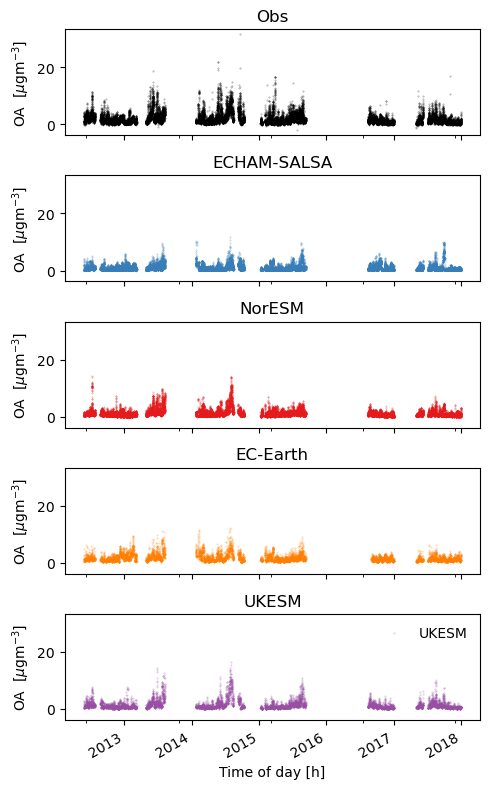

In [129]:
fig, axs = plt.subplots(5,1, sharex=True, sharey=True, figsize=[5,8], dpi=100)
ax = axs[1]
#pl_obs = df_anom_OA['Obs'].groupby(df_anom_OA['obs'].index.hour).mean()
#pl_obs.plot(ax=ax,label='Observations', c='k')

for ax, mo in zip( axs, df_anom_OA.columns):
 
    _df_anom_OA = df_OA_all.copy()
    _df_anom_OA = _df_anom_OA[_df_anom_OA['Obs'].notna()] # .dropna(axis=0)
    print(mo)
    if mo=='Obs':
        c = 'k'
        ls = 'solid'
        c2 = 'w'
        
    else:
        c=cdic_model[mo]
        ls = linestyle_dic[mo]
        c2='k'
    _df = _df_anom_OA[mo]
        
    _df.plot(ax=ax,c=c,
             #linestyle=ls,
             marker='.', 
             linewidth=0,
             markersize=.7,
             alpha=.4,
             rasterized=True,
             
             label=mo)
    
    ax.set_title(mo)
    #'OsloAeroSec',)# c='k')
        #ax.fill_between(_df_gbm.index, _df_gb33,_df_gb66, color = c,alpha=.2)
    # ax.set_title("$OA'$: Average diurnal anomaly") 
#ax.set_title(f"{seas} $OA'$: Median diurnal anomaly") 

#    ax.set_ylim([-2,2])

ax.legend(frameon=False)


plt.legend(frameon=False)
ax.set_xlabel('Time of day [h]')
for ax in axs: 
    ax.set_ylabel('OA  [$\mu$gm$^{-3}$]')
plt.tight_layout()

#ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22,])

#ax.set_xlim([0,23])
fn = make_fn_eval('_'.join(models), 'timeseries')

fig.savefig(fn.with_suffix('.png'))
fig.savefig(fn.with_suffix('.pdf'))
print(fn)

In [51]:
from bs_fdbck.util.BSOA_datamanip.atto import season2month

Plots/SMR/evalOA_echam_ECHAM-SALSA_NorESM_EC-Earth_UKESM_diurnal_mean_dev_JA_SMR.png


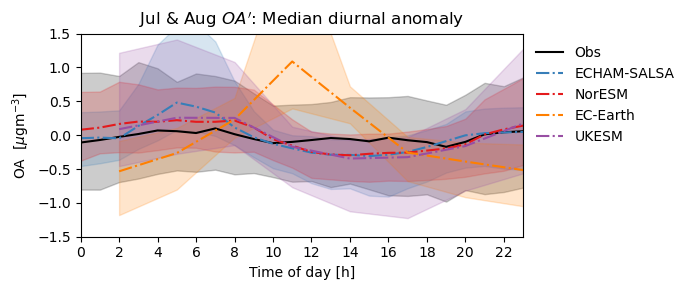

In [67]:
fig, ax = plt.subplots(1,1, sharex=True, figsize=[7,3], dpi=100)
seas = 'JA'
    
_df_anom_OA = df_anom_OA[df_anom_OA.index.month.isin(season2month[seas])]
_df_anom_OA = _df_anom_OA[_df_anom_OA['Obs'].notna()]#.dropna(axis=0)

for mod in df_anom_OA.columns:
    if mod=='Obs':
        c = 'k'
    else:
        c=cdic_model[mod]
    if mod in ['UKESM','EC-Earth']:
        # 3h resolution so need to drop nans
        _df_anom_OA = _df_anom_OA[_df_anom_OA[mod].notna()]
    ls = linestyle_dic[mod]
    _df_gb = _df_anom_OA[mod].groupby(_df_anom_OA.index.hour)
    _df_gbm = _df_gb.median()
    _df_gbstd = _df_gb.std()
    _df_gb33 = _df_gb.quantile(.84)
    _df_gb66 = _df_gb.quantile(.16)
    
    
    _df_gbm.plot(ax=ax,c=c,
                                                               linestyle=ls,
                                                               label=mod)#'OsloAeroSec',)# c='k')
    ax.fill_between(_df_gbm.index, _df_gb33,_df_gb66, color = c,alpha=.2)
ax.set_title(f"Jul & Aug $OA'$: Median diurnal anomaly") 

ax.set_ylim([-1.5,1.5])


plt.legend(frameon=False, bbox_to_anchor=(1,1,))
ax.set_xlabel('Time of day [h]')

ax.set_ylabel('OA  [$\mu$gm$^{-3}$]')
plt.tight_layout()

ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22,])

ax.set_xlim([0,23])
fn = make_fn_eval('_'.join(models), 'diurnal_mean_dev_JA')

fig.savefig(fn.with_suffix('.png'))
fig.savefig(fn.with_suffix('.pdf'))
print(fn)

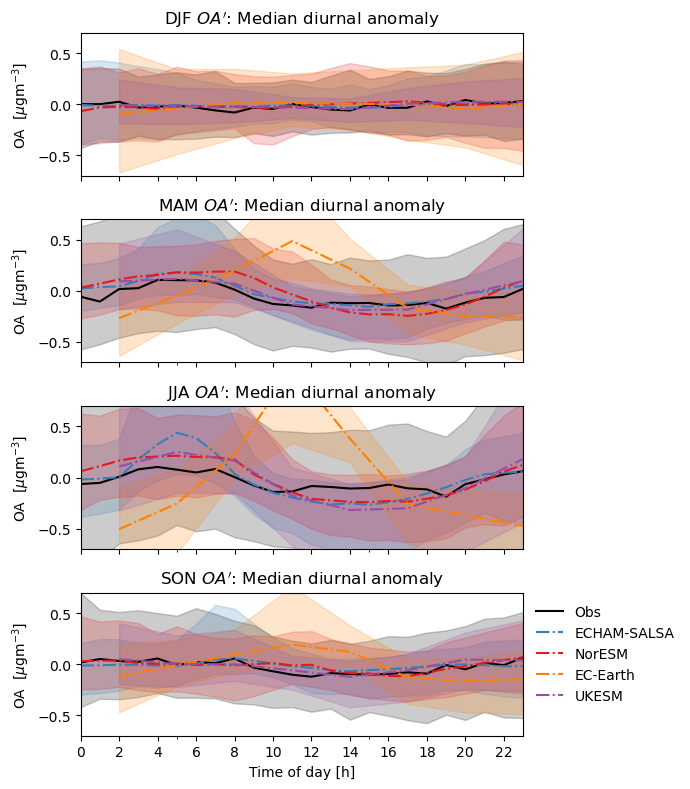

In [116]:
fig, axs = plt.subplots(4,1, sharex=True, figsize=[7,8], dpi=100)
ax = axs[1]
#pl_obs = df_anom_OA['Obs'].groupby(df_anom_OA['obs'].index.hour).mean()
#pl_obs.plot(ax=ax,label='Observations', c='k')

for seas, ax in zip(seasons2months, axs):
    
    _df_anom_OA = df_anom_OA[df_anom_OA.index.month.isin(seasons2months[seas])]
    #_df_anom_OA = _df_anom_OA.dropna(axis=0)
    for mod in df_anom_OA.columns:
        if mod=='Obs':
            c = 'k'
        else:
            c=cdic_model[mod]
            #continue
        if mod in ['UKESM','EC-Earth']:
            # 3h resolution so need to drop nans
            _df_anom_OA = _df_anom_OA[_df_anom_OA[mod].notna()]

        ls = linestyle_dic[mod]
        _df_gb = _df_anom_OA[mod].groupby(_df_anom_OA.index.hour)
        _df_gbm = _df_gb.median()
        _df_gbstd = _df_gb.std()
        _df_gb33 = _df_gb.quantile(.84)
        _df_gb66 = _df_gb.quantile(.16)
        
        
        _df_gbm.plot(ax=ax,c=c,
                                                               linestyle=ls,
                                                               label=mod)#'OsloAeroSec',)# c='k')
        ax.fill_between(_df_gbm.index, _df_gb33,_df_gb66, color = c,alpha=.2)
    # ax.set_title("$OA'$: Average diurnal anomaly") 
    ax.set_title(f"{seas} $OA'$: Median diurnal anomaly") 

    ax.set_ylim([-.7,.7])

#ax.legend(frameon=False)


plt.legend(frameon=False, bbox_to_anchor=(1,1,))
ax.set_xlabel('Time of day [h]')
for ax in axs: 
    ax.set_ylabel('OA  [$\mu$gm$^{-3}$]')
plt.tight_layout()

ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22,])

ax.set_xlim([0,23])
fn = make_fn_eval('_'.join(models), 'diurnal_mean_dev')

fig.savefig(fn.with_suffix('.png'))
fig.savefig(fn.with_suffix('.pdf'))

In [54]:
_df_OA_all = df_OA_all[df_OA_all.index.month.isin(seasons2months[seas])]

_df_OA_all

,Obs,ECHAM-SALSA,NorESM,EC-Earth,UKESM
time,,,,,
2012-09-01 00:00:00,3.730444,1.377884,1.602085,NaN,NaN
2012-09-01 01:00:00,2.883833,1.352896,1.641978,NaN,NaN
2012-09-01 02:00:00,2.334413,1.338986,1.678389,NaN,2.139948
2012-09-01 03:00:00,2.538839,1.329088,1.709599,NaN,NaN
2012-09-01 04:00:00,2.977375,1.317193,1.733932,NaN,NaN
...,...,...,...,...,...
2017-11-30 06:00:00,2.385581,0.588392,2.691388,NaN,NaN
2017-11-30 13:00:00,0.689971,0.923019,1.650231,NaN,NaN
2017-11-30 21:00:00,0.884128,1.087851,0.606067,NaN,NaN


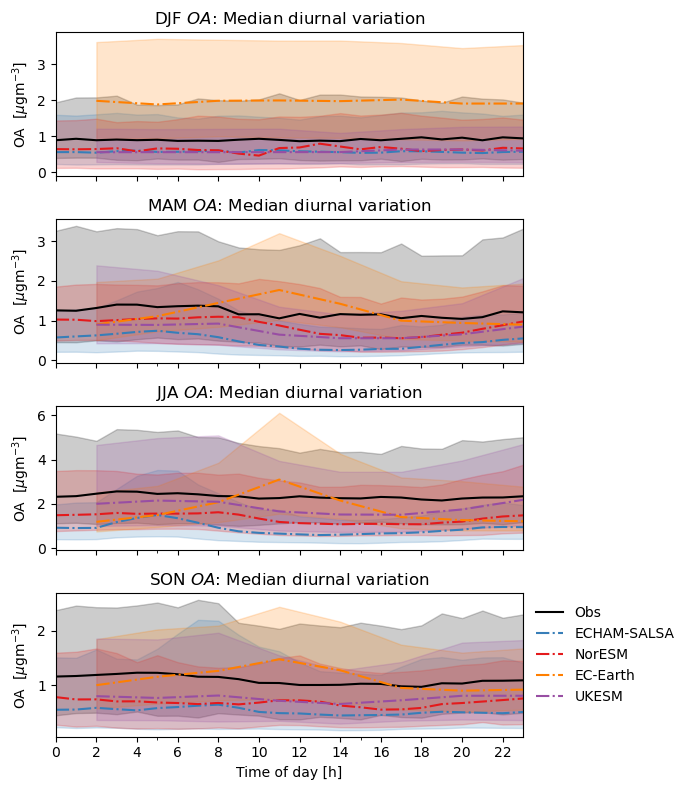

In [117]:
fig, axs = plt.subplots(4,1, sharex=True, figsize=[7,8], dpi=100)
ax = axs[1]
#pl_obs = df_anom_OA['Obs'].groupby(df_anom_OA['obs'].index.hour).mean()
#pl_obs.plot(ax=ax,label='Observations', c='k')

for seas, ax in zip(seasons2months, axs):
    
    _df_OA_all = df_OA_all[df_OA_all.index.month.isin(seasons2months[seas])]
    #_df_OA_all = _df_OA_all.dropna(axis=0)
    for mod in df_OA_all.columns:
        if mod=='Obs':
            c = 'k'
        else:
            c=cdic_model[mod]
            #continue
        if mod in ['UKESM','EC-Earth']:
            # 3h resolution so need to drop nans
            _df_OA_all = _df_OA_all[_df_OA_all[mod].notna()]

        ls = linestyle_dic[mod]
        _df_gb = _df_OA_all[mod].groupby(_df_OA_all.index.hour)
        _df_gbm = _df_gb.median()
        _df_gbstd = _df_gb.std()
        _df_gb33 = _df_gb.quantile(.84)
        _df_gb66 = _df_gb.quantile(.16)
        
        
        _df_gbm.plot(ax=ax,c=c,
                                                               linestyle=ls,
                                                               label=mod)#'OsloAeroSec',)# c='k')
        ax.fill_between(_df_gbm.index, _df_gb33,_df_gb66, color = c,alpha=.2)
    # ax.set_title("$OA'$: Average diurnal anomaly") 
    ax.set_title(f"{seas} $OA$: Median diurnal variation") 

    #ax.set_ylim([-3,3])

plt.legend(frameon=False, bbox_to_anchor=(1,1,))


ax.set_xlabel('Time of day [h]')
for ax in axs: 
    ax.set_ylabel('OA  [$\mu$gm$^{-3}$]')
plt.tight_layout()

ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22,])

ax.set_xlim([0,23])
fn = make_fn_eval('_'.join(models), 'diurnal_mean')

fig.savefig(fn.with_suffix('.png'))
fig.savefig(fn.with_suffix('.pdf'))

Plots/SMR/evalOA_echam_ECHAM-SALSA_NorESM_EC-Earth_UKESM_diurnal_mean_SMR.png


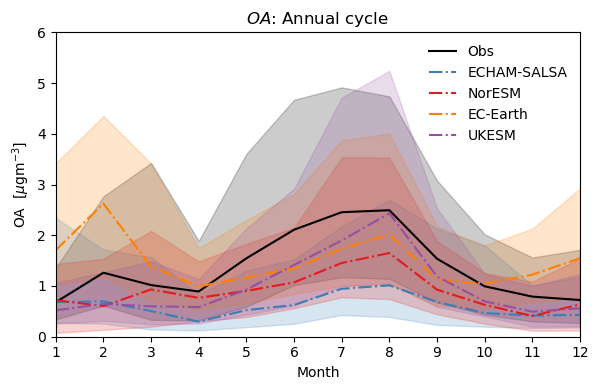

In [56]:
fig, axs = plt.subplots(1,1, sharex=True, figsize=[6,4], dpi=100)
ax = axs
#pl_obs = df_anom_OA['Obs'].groupby(df_anom_OA['obs'].index.hour).mean()
#pl_obs.plot(ax=ax,label='Observations', c='k')

    
_df_OA_all = df_OA_all.copy()#[df_OA_all.index.month.isin(seasons2months[seas])]
#_df_OA_all = _df_OA_all.dropna(axis=0)
for mod in df_OA_all.columns:
    if mod=='Obs':
        c = 'k'
    else:
        c=cdic_model[mod]
    ls = linestyle_dic[mod]
    _df_gb = _df_OA_all[mod].groupby(_df_OA_all.index.month)
    _df_gbm = _df_gb.median()
    _df_gbstd = _df_gb.std()
    _df_gb33 = _df_gb.quantile(.84)
    _df_gb66 = _df_gb.quantile(.16)
    
    _df_gbm.plot(ax=ax,c=c,
                                                               linestyle=ls,
                                                               label=mod)#'OsloAeroSec',)# c='k')
    ax.fill_between(_df_gbm.index, _df_gb33,_df_gb66, color = c,alpha=.2)
    # ax.set_title("$OA'$: Average diurnal anomaly") 
ax.set_title(f"$OA$: Annual cycle") 

ax.set_ylim([0,6])

ax.legend(frameon=False)


plt.legend(frameon=False)
ax.set_xlabel('Month')
ax.set_ylabel('OA  [$\mu$gm$^{-3}$]')
plt.tight_layout()

ax.set_xticks(np.arange(1,13))

ax.set_xlim([1,12])
fn = make_fn_eval('_'.join(models), 'diurnal_mean')

fig.savefig(fn.with_suffix('.png'))
fig.savefig(fn.with_suffix('.pdf'))
print(fn)

In [57]:
import matplotlib as mpl

In [58]:
mi = np.min(df_OA_all[df_OA_all['Obs']>0]['Obs'])*60
ma = np.max(df_OA_all[df_OA_all['Obs']>0]['Obs'])*.9
bins_ = 10 ** np.linspace(np.log10(mi), np.log10(ma), 50)

Plots/SMR/evalOA_echam_noresm_echam_seasons_hist_SMR.png


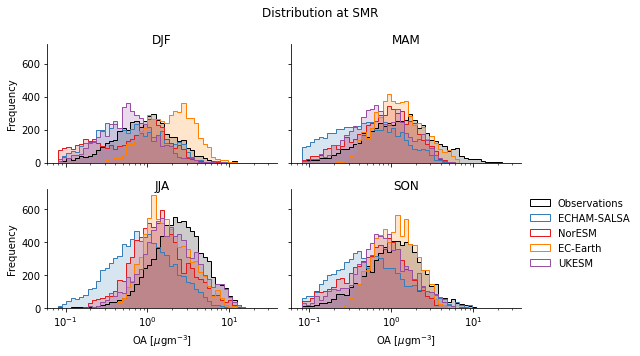

In [118]:
fig, axs = plt.subplots(2,2,figsize = [9,5,],sharex=True, sharey=True)

for seas,ax in zip(seasons2months, axs.flatten()):
    df_OA_all_sub =  df_OA_all.copy()[df_OA_all['Obs'].notna()]
    for mo in ['UKESM','EC-Earth']:
        if mo in df_OA_all.columns:
            df_OA_all_sub[mo] =df_OA_all_sub.loc[:,mo].ffill(limit=3).copy()
            df_OA_all_sub[mo] =df_OA_all_sub[mo][df_OA_all_sub['Obs'].notna()]
        
    df_OA_all_sub = df_OA_all_sub[df_OA_all_sub.index.month.isin(seasons2months[seas])].copy()
    df_OA_all_sub['Obs'].plot.hist(bins=bins_, alpha=1, 
                                     color='k',
                                     label='Observations',
                                   ax = ax,
                                   histtype='step',
                                  )
    df_OA_all_sub['Obs'].plot.hist(bins=bins_, alpha=0.2, 
                                     color='k',
                                     label='__nolabel__',
                                   ax = ax,
                                  )
    for mo in models:

        df_OA_all_sub[mo].plot.hist(bins=bins_, alpha=1, 
                                     color=cdic_model[mo],
                                     label=mo,
                                    ax = ax,
                                    
                                    histtype='step'
                                    )
        df_OA_all_sub[mo].plot.hist(bins=bins_, alpha=0.2, 
                                     color=cdic_model[mo],
                                    
                                     label='__nolabel__',
                                    ax = ax
                                    )

        
    ax.set_xscale('log')
    #_mod_an.plot.hist(bins=bins_, alpha=0.5,label='OsloAero, SOA')

    ax.set_xlabel('OA [$\mu$gm$^{-3}$]')

    ax.set_title(f'{seas}', y=.95)

ax.legend(frameon=False, bbox_to_anchor=(1,1,))

plt.suptitle(f'Distribution at {select_station}')
fn = make_fn_eval('noresm_echam_seasons','hist')
fig.tight_layout()
sns.despine(fig)
plt.savefig(fn, dpi=300)

print(fn)
plt.savefig(fn.with_suffix('.pdf'), dpi=300)

In [119]:
from bs_fdbck.util.BSOA_datamanip.atto import season2month

In [120]:
season2month

{'WET': [1, 2, 3, 4, 5, 6, 7, 12],
 'WET_old': [1, 2, 3, 4, 5],
 'WET_345': [3, 4, 5],
 'WET_45': [4, 5],
 'WET_34': [3, 4],
 'WET_mid': [2, 3, 4, 5],
 'FMAM': [2, 3, 4, 5],
 'JFMAM': [1, 2, 3, 4, 5],
 'WET_early': [1, 2, 3, 12],
 'WET_23': [2, 3],
 'FM': [2, 3],
 'FMA': [2, 3, 4],
 'DJF': [1, 2, 12],
 'JF': [1, 2],
 'JFM': [1, 2, 3],
 'DJ': [1, 12],
 'MJJ': [5, 6, 7],
 'ON': [10, 11],
 'SON': [9, 10, 11],
 'SOND': [9, 10, 11, 12],
 'JJA': [6, 7, 8],
 'JA': [7, 8],
 'MAM': [3, 4, 5],
 'WET_late': [4, 5, 6, 7],
 'DRY': [8, 9, 10, 11],
 'DRY_early': [6, 7, 8],
 'ASO': [8, 9, 10],
 'SO': [9, 10],
 'ND': [11, 12],
 'DRY_late': [9, 10, 11, 12],
 'ALL_year': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}

In [62]:
_df = df_OA_all[df_OA_all['Obs']>0]
_df [_df.index.month.isin(season2month[seas])]
mi = np.min(_df['Obs'])*300
ma = np.max(_df['Obs'])*.9
bins_ = 10 ** np.linspace(np.log10(mi), np.log10(ma), 50)

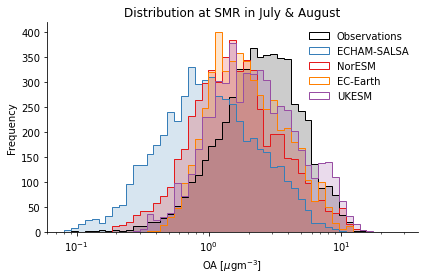

In [121]:
fig, ax = plt.subplots(1,figsize = [6,4,],)
seas ='JA'

df_OA_all_sub = df_OA_all.copy()
for mo in ['EC-Earth','UKESM']:
    if mo in df_OA_all.columns:
        #mo = 'UKESM'
        df_OA_all_sub[mo] =df_OA_all_sub.loc[:,mo].ffill(limit=3).copy()
        df_OA_all_sub[mo] =df_OA_all_sub[mo][df_OA_all_sub['Obs'].notna()]

df_OA_all_sub = df_OA_all_sub[df_OA_all_sub.index.month.isin(season2month[seas])]
df_OA_all_sub['Obs'].plot.hist(bins=bins_, alpha=1, 
                                     color='k',
                                     label='Observations',
                                   ax = ax,
                                   histtype='step',
                                  )
df_OA_all_sub['Obs'].plot.hist(bins=bins_, alpha=0.2, 
                                     color='k',
                                     label='__nolabel__',
                                   ax = ax,
                                  )
for mo in models:
        df_OA_all_sub[mo].plot.hist(bins=bins_, alpha=1, 
                                     color=cdic_model[mo],
                                     label=mo,
                                    ax = ax,
                                    histtype='step'
                                    )
        df_OA_all_sub[mo].plot.hist(bins=bins_, alpha=0.2, 
                                     color=cdic_model[mo],
                                     label='__nolabel__',
                                    ax = ax
                                    )

    #df_OA_all_sub[mo].plot.hist(bins=bins_, alpha=0.5, 
    #                                 color=cdic_model[mo],
    #                                 label=mo,
    #                                ax = ax,
                                #histtype="step",
                                #element='step',
    #                                )
ax.set_xscale('log')
    #_mod_an.plot.hist(bins=bins_, alpha=0.5,label='OsloAero, SOA')

ax.set_xlabel('OA [$\mu$gm$^{-3}$]')


ax.legend(frameon=False)
ax.set_title(f'Distribution at {select_station} in July & August')
fn = make_fn_eval('noresm_echam_JA','hist')
fig.tight_layout()
sns.despine(fig)
plt.savefig(fn, dpi=300)


plt.savefig(fn.with_suffix('.pdf'), dpi=300)

/tmp/ipykernel_209801/2402147210.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['hour'] = _df.index.hour


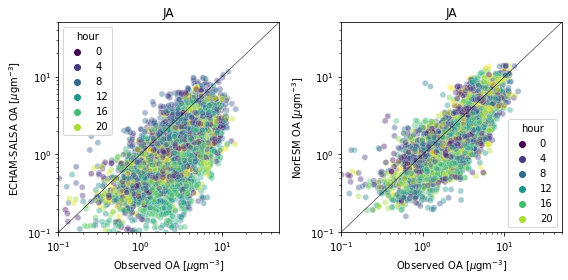

In [64]:
fig, axs = plt.subplots(1,2,figsize = [8,4],sharex=True, sharey=False)
seas = 'JA'
_df = df_OA_all[df_OA_all.index.month.isin(season2month[seas])]
_df['hour'] = _df.index.hour
for mo, ax in zip(models,axs):
    sns.scatterplot(y=mo, x='Obs',#orbins=bins_, alpha=0.5, 
                                     hue='hour', 
                #col = 'dir',
                ax=ax,
                alpha=0.4,
                palette='viridis',
                
                edgecolors=None,
                data = _df)

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim([0.1,50])
    ax.set_ylim([0.1,50])

    ax.set_ylabel(f'{mo} OA '+'[$\mu$gm$^{-3}$]')
    ax.set_xlabel('Observed OA [$\mu$gm$^{-3}$]')
    ax.set_title(seas)


    lims = ax.get_xlim()
    ax.plot(lims,lims,'k', linewidth=.5)

fig.tight_layout()

fn = make_fn_eval('_'.join(models),'scatt_JA')
fig.savefig(fn, dpi=300)
fig.savefig(fn.with_suffix('.pdf'), dpi=300)

Plots/SMR/evalOA_echam_noresm_echam_seasons_hist_SMR.png


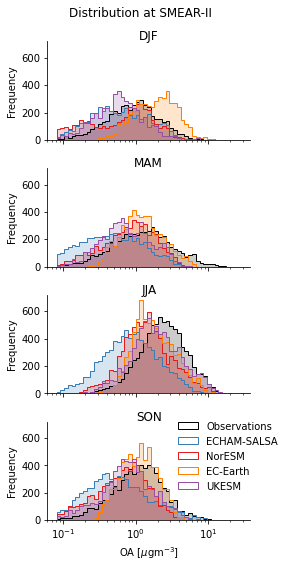

In [123]:
fig, axs = plt.subplots(4,figsize = [4,8,],sharex=True, sharey=True)

for seas,ax in zip(seasons2months, axs.flatten()):
    df_OA_all_sub = df_OA_all.copy()
    for mo in ['UKESM','EC-Earth']:
        if mo in df_OA_all.columns:
        
            df_OA_all_sub[mo] =df_OA_all_sub.loc[:,mo].ffill(limit=3).copy()
            df_OA_all_sub[mo] =df_OA_all_sub[mo][df_OA_all_sub['Obs'].notna()]

    df_OA_all_sub = df_OA_all_sub[df_OA_all_sub.index.month.isin(season2month[seas])]
    

    df_OA_all_sub['Obs'].plot.hist(bins=bins_, alpha=1, 
                                     color='k',
                                     label='Observations',
                                   ax = ax,
                                   histtype='step',
                                  )
    df_OA_all_sub['Obs'].plot.hist(bins=bins_, alpha=0.2, 
                                     color='k',
                                     label='__nolabel__',
                                   ax = ax,
                                  )

    for mo in models:
        df_OA_all_sub[mo].plot.hist(bins=bins_, alpha=1, 
                                     color=cdic_model[mo],
                                     label=mo,
                                    ax = ax,
                                    histtype='step'
                                    )
        df_OA_all_sub[mo].plot.hist(bins=bins_, alpha=0.2, 
                                     color=cdic_model[mo],
                                     label='__nolabel__',
                                    ax = ax
                                    )
    ax.set_xscale('log')
    #_mod_an.plot.hist(bins=bins_, alpha=0.5,label='OsloAero, SOA')

    ax.set_xlabel('OA [$\mu$gm$^{-3}$]')

    ax.set_title(f'{seas}', y=.95)

ax.legend(frameon=False, bbox_to_anchor=(.6,.2,))
plt.suptitle('Distribution at SMEAR-II')
fn = make_fn_eval('noresm_echam_seasons','hist')
fig.tight_layout()
sns.despine(fig)
plt.savefig(fn, dpi=300)
print(fn)

plt.savefig(fn.with_suffix('.pdf'), dpi=300)

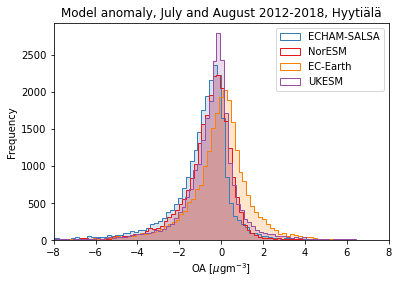

In [124]:
df_OA_all_sub = df_OA_all.copy()
for mo in ['UKESM','EC-Earth']:
    if mo in df_OA_all.columns:
        df_OA_all_sub[mo] =df_OA_all_sub.loc[:,mo].ffill(limit=3).copy()
        df_OA_all_sub[mo] =df_OA_all_sub[mo][df_OA_all_sub['Obs'].notna()]

for mo in models:
    
    (df_OA_all_sub[mo]-df_OA_all_sub['Obs']).plot.hist(#bins=bins_, 
        alpha=1, 
        bins=200,
        color = cdic_model[mo],
                                     #color=None,
                                     label=mo,
        histtype='step',
                                    )
    (df_OA_all_sub[mo]-df_OA_all_sub['Obs']).plot.hist(#bins=bins_, 
        alpha=0.2, 
        bins=200,
        color = cdic_model[mo],
                                     #color=None,
                                     label='__nolabel__',
                                    )

    #plt.xscale('log')
#_mod_an.plot.hist(bins=bins_, alpha=0.5,label='OsloAero, SOA')
plt.xlim([-8,8])
plt.xlabel('OA [$\mu$gm$^{-3}$]')

plt.title('Model anomaly, July and August 2012-2018, Hyytiälä')

plt.legend()
fn = make_fn_eval('diff_hist','hist')
plt.savefig(fn, dpi=300)
plt.savefig(fn.with_suffix('.pdf'), dpi=300)

In [125]:
import numpy as np

In [126]:
_df = df_OA_all[df_OA_all['Obs']>0]
_df [_df.index.month.isin(season2month[seas])]
mi = np.min(_df['Obs'])*300
ma = np.max(_df['Obs'])*.9
bins_ = 10 ** np.linspace(np.log10(mi), np.log10(ma), 50)

/tmp/ipykernel_209801/3044914887.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['hour'] = _df.index.hour
/tmp/ipykernel_209801/3044914887.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['hour'] = _df.index.hour
/tmp/ipykernel_209801/3044914887.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

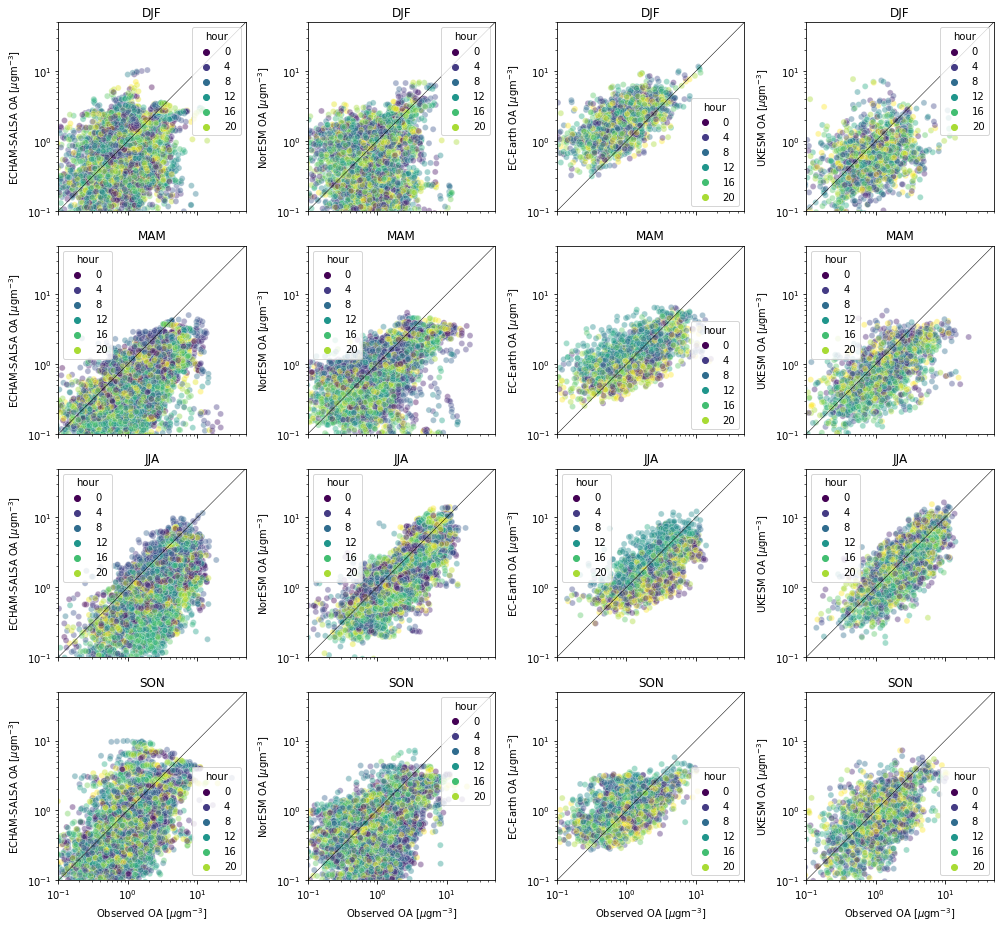

In [127]:
fig, axs = plt.subplots(4,4,figsize = [14,13],sharex=True, sharey=False)

for seas,i in zip(seasons2months, range(4)):
    axs_sub = axs[i]
    _df = df_OA_all[df_OA_all.index.month.isin(seasons2months[seas])]

    _df['hour'] = _df.index.hour
    for mo, ax in zip(models,axs_sub):
        sns.scatterplot(y=mo, x='Obs',#orbins=bins_, alpha=0.5, 
                                     hue='hour', 
                #col = 'dir',
                ax=ax,
                alpha=0.4,
                palette='viridis',
                
                edgecolors=None,
                data = _df)

        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_xlim([0.1,50])
        ax.set_ylim([0.1,50])

        ax.set_ylabel(f'{mo} OA '+'[$\mu$gm$^{-3}$]')
        ax.set_xlabel('Observed OA [$\mu$gm$^{-3}$]')
        ax.set_title(seas)


        lims = ax.get_xlim()
        ax.plot(lims,lims,'k', linewidth=.5)

fig.tight_layout()

fn = make_fn_eval('_'.join(models),'scatt')
fig.savefig(fn, dpi=300)
fig.savefig(fn.with_suffix('.pdf'), dpi=300)

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inp

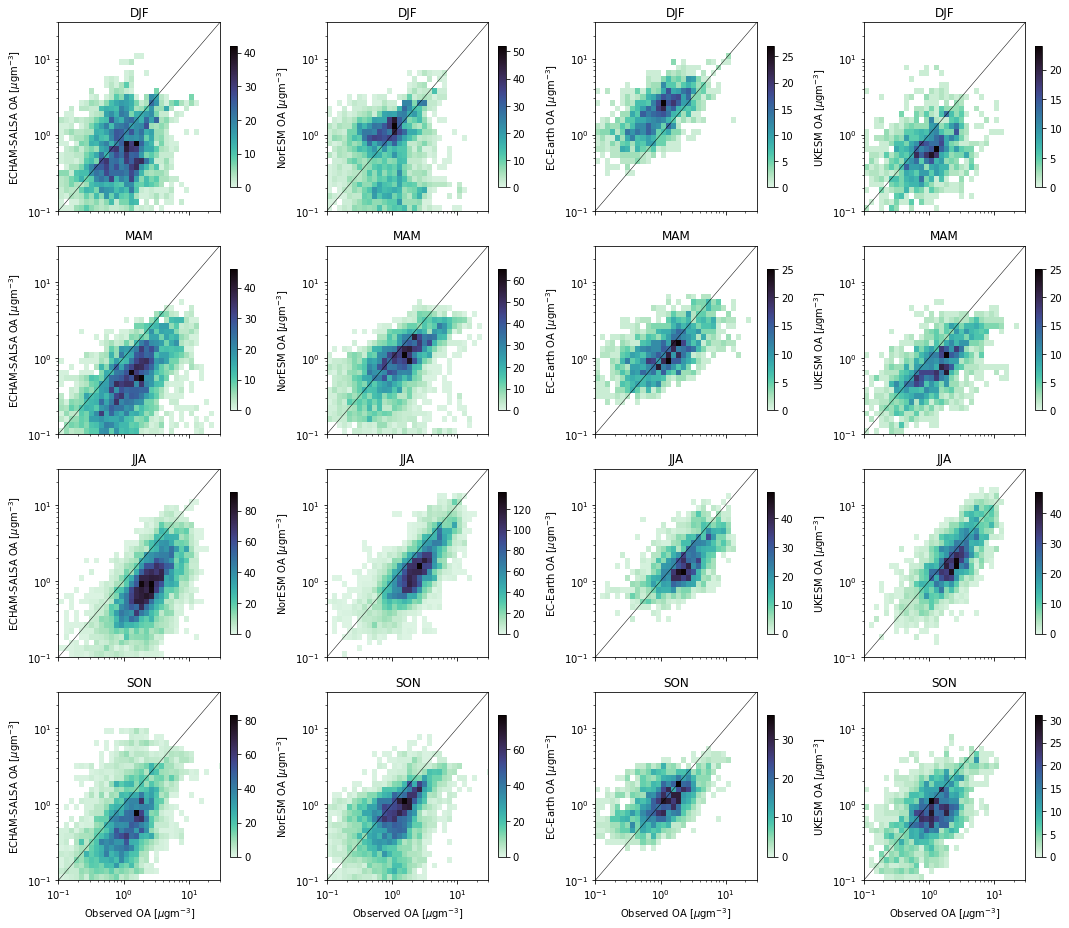

In [128]:
fig, axs = plt.subplots(4,4,figsize = [15,13],sharex=True, sharey=False)

for seas,i in zip(['DJF','MAM','JJA','SON'], range(4)):
    axs_sub = axs[i]
    _df = df_OA_all[df_OA_all.index.month.isin(season2month[seas])]
    bins = np.linspace(-1,2,40)
    #_df['hour'] = _df.index.hour
    for mo, ax in zip(models,axs_sub):
        sns.histplot(y=mo, x='Obs',
                ax=ax,
                cmap = sns.color_palette("mako_r", as_cmap=True),
                log_scale=(True, True),
                     cbar=True, cbar_kws=dict(shrink=.75),
                
                edgecolors=None,
                     bins=(bins,bins,),
                data = _df)


        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_xlim([0.1,30])
        ax.set_ylim([0.1,30])

        ax.set_ylabel(f'{mo} OA '+'[$\mu$gm$^{-3}$]')
        ax.set_xlabel('Observed OA [$\mu$gm$^{-3}$]')

        ax.set_title(seas)


        lims = ax.get_xlim()
        ax.plot(lims,lims,'k', linewidth=.5)

fig.tight_layout()

fn = make_fn_eval('_'.join(models),'2Dhist_seasons_OA')
fig.savefig(fn, dpi=300)
fig.savefig(fn.with_suffix('.pdf'), dpi=300)

/tmp/ipykernel_95527/3588501555.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['hour'] = _df.index.hour
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/x_sarbl/miniconda3/envs/env_

Plots/SMR/evalOA_echam_ECHAM-SALSA_NorESM_EC-Earth_UKESM_season_JA_2dist_OA_conc_SMR.png


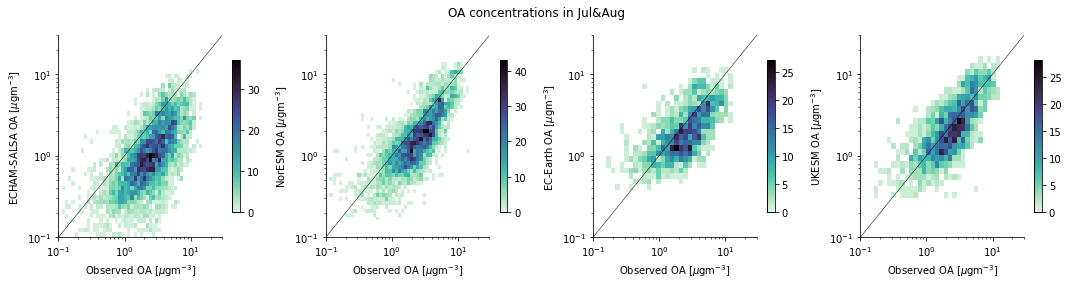

In [71]:
fig, axs = plt.subplots(1,4,figsize = [15,4],sharex=True, sharey=False)
seas = 'JA'
_df = df_OA_all[df_OA_all.index.month.isin(season2month[seas])]
_df['hour'] = _df.index.hour
for mo, ax in zip(models,axs):
    sns.histplot(y=mo, x='Obs',#orbins=bins_, alpha=0.5, 
                                    # hue='hour', 
                #col = 'dir',
                ax=ax,
                cmap = sns.color_palette("mako_r", as_cmap=True),
                log_scale=(True, True),
                     cbar=True, cbar_kws=dict(shrink=.75),
                
                edgecolors=None,
                 
                data = _df)


    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim([0.1,30])
    ax.set_ylim([0.1,30])

    ax.set_ylabel(f'{mo} OA '+'[$\mu$gm$^{-3}$]')
    ax.set_xlabel('Observed OA [$\mu$gm$^{-3}$]')



    lims = ax.get_xlim()
    ax.plot(lims,lims,'k', linewidth=.5)

fig.suptitle(f'OA concentrations in Jul&Aug')

fn = make_fn_eval('_'.join(models),f'season_{seas}_2dist_OA_conc')
print(fn)
sns.despine(fig)
fig.tight_layout()
fig.savefig(fn, dpi=300)
fig.savefig(fn.with_suffix('.pdf'), dpi=300)

NameError: name 'df_OA_incDiff' is not defined

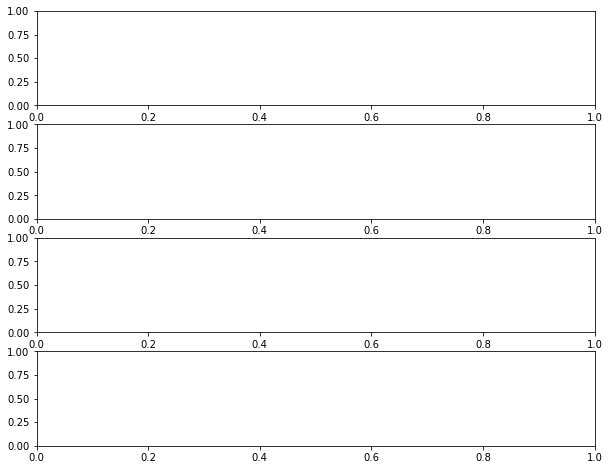

In [72]:
fig, axs = plt.subplots(4,sharey=True, figsize=[10,8])
ax = axs[0]
_df = df_OA_incDiff
_df['hour'] = _df.index.hour
for mo, ax in zip(models,axs.flatten()):
    sns.histplot(y=f'{mo}_diff', x=f'hour',#orbins=bins_, alpha=0.5, 
                                     #hue=f'Obs', 
                #col = 'dir',
                ax=ax,
                #alpha=0.4,
                cmap='YlGnBu',
                 
                
                #edgecolors=None,
                data = _df)

    #ax.set_yscale('log')
    # ax.set_xscale('symlog')
    ax.set_ylim([-3.5,3.5])
    #ax.set_ylim([0.1,30])

    #ax.set_xlabel(f'{mo} OA '+'[$\mu$gm$^{-3}$]')
    #ax.set_ylabel('Observed OA [$\mu$gm$^{-3}$]')



    lims = ax.get_xlim()
    #ax.plot(lims,lims,'k', linewidth=.5)

    #_df.groupby('hour').count().plot(ax = ax.twinx())
    
fn = make_fn_eval('_'.join(models),'2dhist_dist_time')
fig.savefig(fn, dpi=300)
fig.savefig(fn.with_suffix('.pdf'), dpi=300)